# AIFFELTHON -  [WONJIN]

In [7]:
import numpy as np # linear algebra
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
import librosa, librosa.display 
import librosa as lb
import nlpaug.augmenter.audio as naa
from nlpaug.util.audio.visualizer import AudioVisualizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import Audio
import os
import tensorflow_io as tfio
from scipy import signal
from scipy.signal import butter, freqz, filtfilt, find_peaks 
import random
import soundfile as sf

root = '/content/drive/MyDrive/hacker/aiffelthon/aiffelthon'
sr = 16000

In [23]:
#위에서 패딩 및 컷팅한 작업을 새로운 데이터프레임으로 생성하여 data2로 지정함
data2 = pd.read_csv('/content/drive/MyDrive/hacker/aiffelthon/aiffelthon/no_zeropadding.csv')
data2.head()

,Unnamed: 0,start,end,pid,mode,filename,disease,crack_wheeze
0,0,1.862,5.718,160,mc,160_1b3_Ar_mc_AKGC417L_0.wav,COPD,2
1,1,5.718,9.725,160,mc,160_1b3_Ar_mc_AKGC417L_1.wav,COPD,2
2,2,9.725,13.614,160,mc,160_1b3_Ar_mc_AKGC417L_2.wav,COPD,2
3,3,13.614,17.671,160,mc,160_1b3_Ar_mc_AKGC417L_3.wav,COPD,2
4,4,17.671,19.541,160,mc,160_1b3_Ar_mc_AKGC417L_4.wav,COPD,0


In [118]:
data2.drop(['Unnamed: 0'], axis = 1)

,start,end,pid,mode,filename,disease,crack_wheeze
0,1.862,5.718,160,mc,160_1b3_Ar_mc_AKGC417L_0.wav,COPD,2
1,5.718,9.725,160,mc,160_1b3_Ar_mc_AKGC417L_1.wav,COPD,2
2,9.725,13.614,160,mc,160_1b3_Ar_mc_AKGC417L_2.wav,COPD,2
3,13.614,17.671,160,mc,160_1b3_Ar_mc_AKGC417L_3.wav,COPD,2
4,17.671,19.541,160,mc,160_1b3_Ar_mc_AKGC417L_4.wav,COPD,0
...,...,...,...,...,...,...,...
6893,9.393,11.764,159,sc,159_1b1_Pr_sc_Meditron_4.wav,Healthy,0
6894,11.764,14.050,159,sc,159_1b1_Pr_sc_Meditron_5.wav,Healthy,0
6895,14.050,16.521,159,sc,159_1b1_Pr_sc_Meditron_6.wav,Healthy,0
6896,16.521,18.907,159,sc,159_1b1_Pr_sc_Meditron_7.wav,Healthy,0


# Augumentation Test

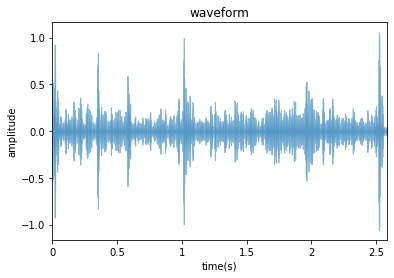

In [42]:
librosa.display.waveplot(Xtrain_1[0], sr=sr, alpha = 0.5)
plt.xlabel("time(s)")
plt.ylabel("amplitude")
plt.title("waveform")
plt.show()

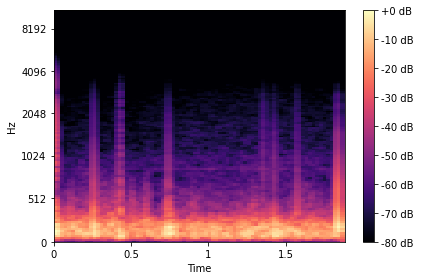

In [43]:
mel_test = lb.feature.melspectrogram(Xtrain_1[0], sr)
mel_db = lb.power_to_db(mel_test, ref = np.max)


img = librosa.display.specshow(mel_db, y_axis = 'mel', x_axis = 'time')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

# Data based augumentation

In [44]:
data2= pd.read_csv('/content/drive/MyDrive/hacker/aiffelthon/aiffelthon/processed.csv') # augmentation 작업용

In [45]:
#본 split은 학습용이 아닌 라벨링 값을 균일하게 가져오기 위해 사용함.
Xtrain_aug,Xval_aug,ytrain_aug,yval_aug=train_test_split(data2, data2.crack_wheeze, stratify=data2.crack_wheeze, random_state=42,test_size=0.2)

데이터프레임에 filename에 있는 파일들은 전부 제로패딩되어있는 부분들이기 때문에 제로패딩이 없는 것들을 합쳐서 제로패딩을 해야함.

In [46]:
Xtrain_aug['crack_wheeze'].value_counts()

0    2913
1    1491
2     709
3     405
Name: crack_wheeze, dtype: int64

In [47]:
Xtrain_aug.head()

,Unnamed: 0,start,end,pid,mode,filename,disease,crack_wheeze
2116,2116,16.948,19.535,198,mc,198_6p1_Lr_mc_AKGC417L_6.wav,COPD,1
6324,6324,4.316,6.149,154,mc,154_1b3_Pl_mc_AKGC417L_2.wav,COPD,1
4923,4923,8.063,10.950,130,mc,130_3b3_Ll_mc_AKGC417L_2.wav,COPD,1
3575,3575,5.307,6.636,102,sc,102_1b1_Ar_sc_Meditron_3.wav,Healthy,0
6815,6815,2.980,5.217,158,mc,158_1p4_Pr_mc_AKGC417L_1.wav,COPD,3


# (1) 클래스별 분류

In [48]:
normal = Xtrain_aug.loc[Xtrain_aug['crack_wheeze'] == 0]
print ('정상인 호흡음의 갯수 : ', len(normal))

crackle = Xtrain_aug.loc[Xtrain_aug['crack_wheeze'] == 1]
print ('Crackle의 갯수 : ',len(crackle))

wheezing =  Xtrain_aug.loc[Xtrain_aug['crack_wheeze'] == 2]
print ('Wheezing의 갯수 : ',len(wheezing))

both = Xtrain_aug.loc[Xtrain_aug['crack_wheeze'] == 3]
print ('Crackle 및 wheezing 둘다 있는 경우의 갯수 : ',len(both))


정상인 호흡음의 갯수 :  2913
Crackle의 갯수 :  1491
Wheezing의 갯수 :  709
Crackle 및 wheezing 둘다 있는 경우의 갯수 :  405


In [49]:
# normal_docs = []
# normal_audio_np = []

# for i in normal.filename:
#   path3 = path2 + i
#   normal_docs.append(path3)

# for j in range(len(normal_docs)):
#   normal_audio,_ = librosa.load(normal_docs[j], sr = sr)
#   normal_audio_np.append(normal_audio)

# normal_audio_np[:2]

In [50]:
# crackle_docs = []
# crackle_audio_np = []

# for i in crackle.filename:
#   path3 = path2 + i
#   crackle_docs.append(path3)

# for j in range(len(crackle_docs)):
#   crackle_audio,_ = librosa.load(crackle_docs[j], sr = sr)
#   crackle_audio_np.append(crackle_audio)

# crackle_audio_np[:2]

In [51]:
# wheezing_docs = []
# wheezing_audio_np = []

# for i in wheezing.filename:
#   path3 = path2 + i
#   wheezing_docs.append(path3)

# for j in range(len(wheezing_docs)):
#   wheezing_audio,_ = librosa.load(wheezing_docs[j], sr = sr)
#   wheezing_audio_np.append(wheezing_audio)

# wheezing_audio_np[:2]

In [52]:
# both_docs = []
# both_audio_np = []

# for i in both.filename:
#   path3 = path2 + i
#   both_docs.append(path3)

# for j in range(len(both_docs)):
#   both_audio,_ = librosa.load(both_docs[j], sr = sr)
#   both_audio_np.append(both_audio)

# both_audio_np[:2]

In [53]:
# root_norm = '/content/drive/MyDrive/hacker/aug_norm/' # 따로 사용하지는 않음
# root_crackle = '/content/drive/MyDrive/hacker/aug_crackle/'
# root_wheezing = '/content/drive/MyDrive/hacker/aug_wheezing/'
# root_both = '/content/drive/MyDrive/hacker/aug_both/'

In [54]:
# def getPureSample(raw_data,start,end,sr=16000):처음 패딩작업을 했을 때는 start와 end를 기준으로 각각을 짤라주었지만,
# 이번에 하는 작업은 두가지를 concat을 한것을 붙여서 7초로 만들 것이기 때문에 end를 7로 설정하여 짜르도록함.
def getPureSample(raw_data,end = 7*16000):
  if len(raw_data) > end:
    return raw_data[:end]
  else:
    return raw_data

In [55]:
# augment normal (test용)

# scale = 1
# aug_nos = scale * len(normal_audio_np) - len(normal_audio_np)

# for idx in range(10):
#   i = random.randint(0, len(normal_audio_np)-1)
#   j = random.randint(0, len(normal_audio_np)-1)

#   normal_i = normal_audio_np[i]
#   normal_j = normal_audio_np[j]
#   new_sample = np.concatenate([normal_i, normal_j])
#   filename= 'aug_normal' + '_' + str(idx) + '.wav'

#   sf.write(file = root_aug + filename , data=new_sample, samplerate = sr)

In [56]:
# augment crackle (1422개의 wave파일을 추가 생성함)

# scale = 1

# aug_nos = scale * len(normal_audio_np) - len(crackle_audio_np)

# for idx in range(aug_nos):
#   aug_prob = random.random()

#   if aug_prob < 0.6:
#     #crakle_i + crackle_j
#     i = random.randint(0,len(crackle_audio_np)-1)
#     j = random.randint(0,len(crackle_audio_np)-1)
#     sample_i = crackle_audio_np[i]
#     sample_j = crackle_audio_np[j]

#   elif aug_prob >= 0.6 and aug_prob < 0.8:
#     # crakle_i + nomrmal_j
#     i = random.randint(0,len(crackle_audio_np)-1)
#     j = random.randint(0,len(normal_audio_np)-1)
#     sample_i = crackle_audio_np[i]
#     sample_j = normal_audio_np[j]

#   else :
#     # normal_i + crakcle_j
#     i = random.randint(0,len(normal_audio_np)-1)
#     j = random.randint(0,len(crackle_audio_np)-1)
#     sample_i = normal_audio_np[i]
#     sample_j = crackle_audio_np[j]

#   new_sample = np.concatenate([sample_i, sample_j])

#   filename= 'aug_crackle' + '_' + str(idx) + '.wav'

#   sf.write(file = root_crackle + filename , data=new_sample, samplerate = sr)


In [57]:
# augment wheezing (2204개의 wave파일을 추가 생성함)

# scale = 1

# aug_nos = scale * len(normal_audio_np) - len(wheezing_audio_np)

# for idx in range(aug_nos):
#   aug_prob = random.random()

#   if aug_prob < 0.6:
#     # wheeze_i + wheeze_j
#     i = random.randint(0,len(wheezing_audio_np)-1)
#     j = random.randint(0,len(wheezing_audio_np)-1)
#     sample_i = wheezing_audio_np[i]
#     sample_j = wheezing_audio_np[j]

#   elif aug_prob >= 0.6 and aug_prob < 0.8:
#      # wheeze_i + normal_j
#     i = random.randint(0,len(wheezing_audio_np)-1)
#     j = random.randint(0,len(normal_audio_np)-1)
#     sample_i = wheezing_audio_np[i]
#     sample_j = normal_audio_np[j]

#   else :
#     # normal_i + wheeze_j
#     i = random.randint(0,len(normal_audio_np)-1)
#     j = random.randint(0,len(wheezing_audio_np)-1)
#     sample_i = normal_audio_np[i]
#     sample_j = wheezing_audio_np[j]

#   new_sample = np.concatenate([sample_i, sample_j])

#   filename= 'aug_wheezing' + '_' + str(idx) + '.wav'

#   sf.write(file = root_wheezing + filename , data=new_sample, samplerate = sr)

In [58]:
# augment both (2508개의 wave파일을 추가 생성함)

# scale = 1

# aug_nos = scale * len(normal_audio_np) - len(both_audio_np)

# for idx in range(aug_nos):
#   aug_prob = random.random()

#   if aug_prob < 0.5:
#     # both_i + both_j
#     i = random.randint(0,len(both_audio_np)-1)
#     j = random.randint(0,len(both_audio_np)-1)
#     sample_i = both_audio_np[i]
#     sample_j = both_audio_np[j]

#   elif aug_prob >= 0.5 and aug_prob < 0.7:
#      # crackle_i + wheeze_j
#     i = random.randint(0,len(crackle_audio_np)-1)
#     j = random.randint(0,len(wheezing_audio_np)-1)
#     sample_i = crackle_audio_np[i]
#     sample_j = wheezing_audio_np[j]

#   elif aug_prob >= 0.7 and aug_prob < 0.8:
#      # wheeze_i + crackle_j
#     i = random.randint(0,len(wheezing_audio_np)-1)
#     j = random.randint(0,len(crackle_audio_np)-1)
#     sample_i = wheezing_audio_np[i]
#     sample_j = crackle_audio_np[j]

#   elif aug_prob >= 0.8 and aug_prob < 0.9:
#     # both_i + normal_j
#     i = random.randint(0,len(both_audio_np)-1)
#     j = random.randint(0,len(normal_audio_np)-1)
#     sample_i = both_audio_np[i]
#     sample_j = normal_audio_np[j]

#   else:
#     # normal_i + both_j
#     i = random.randint(0,len(normal_audio_np)-1)
#     j = random.randint(0,len(both_audio_np)-1)
#     sample_i = normal_audio_np[i]
#     sample_j = both_audio_np[j]

#   new_sample = np.concatenate([sample_i, sample_j])

#   filename= 'aug_both' + '_' + str(idx) + '.wav'

#   sf.write(file = root_both + filename , data=new_sample, samplerate = sr)
